# Prediction on test dataset

In [1]:
import os
import matplotlib.pyplot as plt
import json
import torch
import numpy as np

from torch.utils.data import Dataset, DataLoader
from monai.transforms import(
    AsDiscrete, 
    Compose, 
    
)
from monai.metrics import DiceMetric, MeanIoU
from data_utils import * 
from model import SwinUNETR

# Comparisons of different models

In [7]:
# pretrained_paths = ['log_ckp/AS5_0502_3T/fold0_model_bestVal_ckp.pt', 'log_ckp/11_0330/fold3_model_bestVal_ckp.pt', 'log_ckp/MT06_0504_3T/fold1_model_bestVal_ckp.pt']
pretrained_paths = ['log/AS5_0419_7T/best_model_fold2_epoch.pt', 'log/16_0407_7T/best_model_fold2_epoch.pt', 'log/MT02_0408_7T/best_model_fold1_epoch.pt']
# pretrained_paths = ['log/MT02_0408_7T/best_model_fold1_epoch.pt', 'log/MT03_0419_7T/best_model_fold1_epoch.pt']

model_args = {
        'img_size': (512, 512),
#         'img_size': (256, 256),
        'in_channels': 1,
        'out_channels': 1,
        'feature_size': 4,
        'use_checkpoint': True,
        'spatial_dims': 2
    }

model = SwinUNETR(
        img_size=model_args['img_size'],
        in_channels=model_args['in_channels'], # grayscale
        out_channels=model_args['out_channels'], # single class seg
        feature_size =model_args['feature_size'], # embedding size (default: 24), TBC
        use_checkpoint=model_args['use_checkpoint'],
        spatial_dims=model_args['spatial_dims']
    )

batch_size = 14
num_workers = 4
# json_path = 'OAIdataset/3TMRI_dataset_1.json'
json_path = '7TMRIs/7TMRI_dataset.json'
# json_path = '7TMRIs/7TMRI_dataset_all.json'
dice_accuracy = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
iou_accuracy = MeanIoU(include_background=False, reduction="mean", get_not_nans=False)


train_list, test_list = load_dataset(json_path)
# test_list = test_list[:32] # change this for different number of predictions

test_transforms = transforms.Compose([
        transforms.Resize((512, 512)),
#         transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

test_ds = HDF5Dataset(data=test_list, transform=test_transforms)
print('Number of test images: ', len(test_ds))

testDataloader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)


###### Test loop ######
all_pred_masks = []

for path in pretrained_paths:
    model_dict = torch.load(path, map_location=torch.device('cpu'))["state_dict"]
    model.load_state_dict(model_dict)
    model.eval()

    dices = []
    ious = []
    pred_masks = []
    
    print('Model: ', path)
    with torch.no_grad():
        for step, batch in enumerate(testDataloader):
            data, target = batch
    #         data, target = data.cuda(0), target.cuda(0)

            y_pred = model(data)

            y_pred = torch.sigmoid(y_pred)
            y_pred = (y_pred > 0.5).float()

            target = (target > 0).float()

            dice_accuracy(y_pred=y_pred, y=target)
            mean_dice = dice_accuracy.aggregate().item()
            dices.append(mean_dice)
#             dices.append(dice_accuracy)
#             print(dice_accuracy)
            
            
            iou_accuracy(y_pred=y_pred, y=target)
            mean_iou = iou_accuracy.aggregate().item()
            ious.append(mean_iou)
#             ious.append(iou_accuracy)

#             print('Batch dice score: ', mean_dice, ' Batch IoU: ', mean_iou)

            pred_mask = y_pred.numpy()
            pred_masks.append(pred_mask)

    all_pred_masks.append(pred_masks)
    print('Average Dice score on test data: ', np.mean(dices), ' +/- ', np.std(dices))
    print('Average IoU on test data: ', np.mean(ious), ' +/- ', np.std(ious))
    print()
    
    

Number of test images:  14
Model:  log/AS5_0419_7T/best_model_fold2_epoch.pt
Average Dice score on test data:  0.9259409308433533  +/-  0.0
Average IoU on test data:  0.8625917434692383  +/-  0.0

Model:  log/16_0407_7T/best_model_fold2_epoch.pt
Average Dice score on test data:  0.9288010001182556  +/-  0.0
Average IoU on test data:  0.8675077557563782  +/-  0.0

Model:  log/MT02_0408_7T/best_model_fold1_epoch.pt
Average Dice score on test data:  0.9319041967391968  +/-  0.0
Average IoU on test data:  0.872921884059906  +/-  0.0



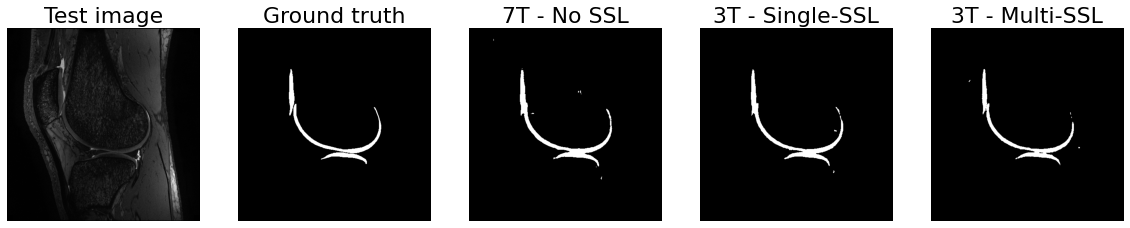

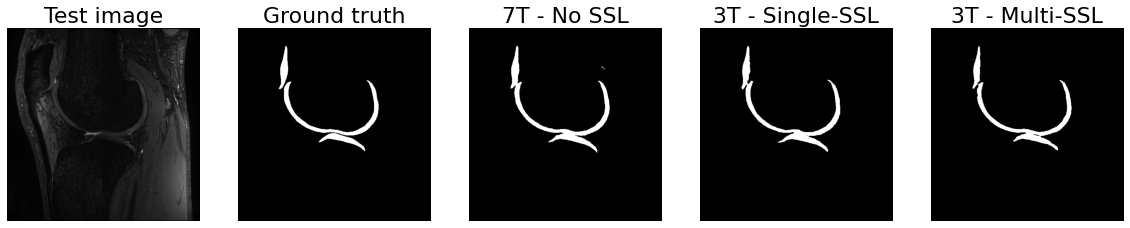

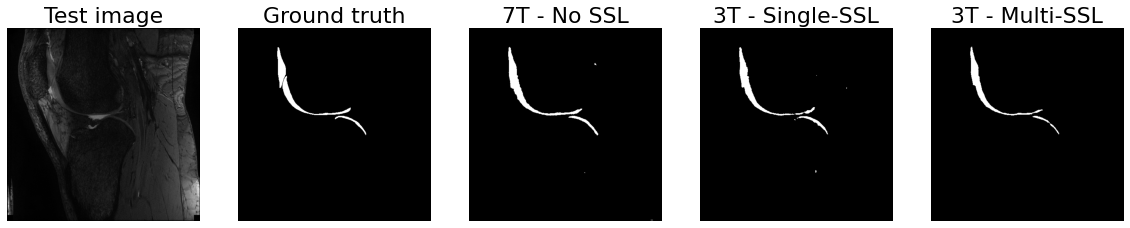

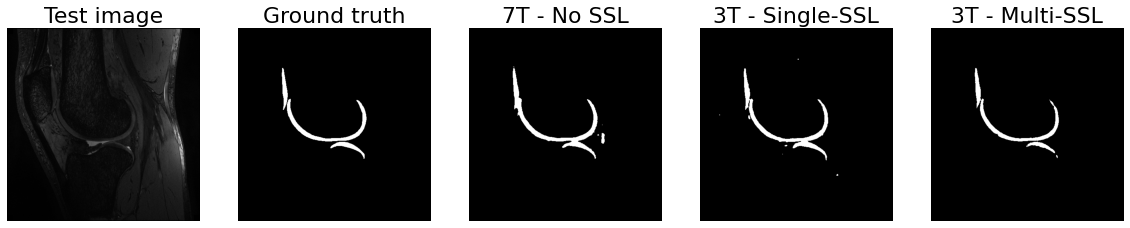

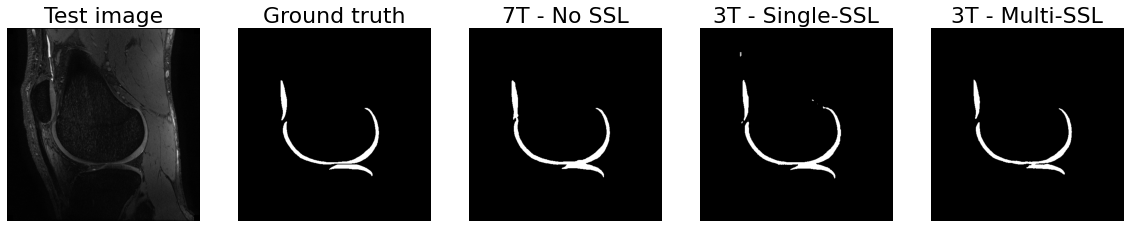

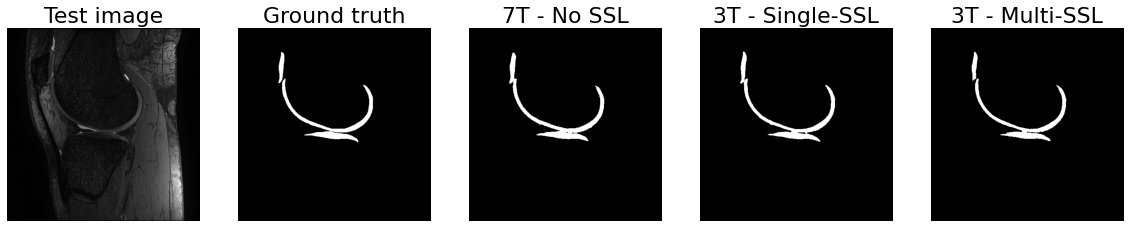

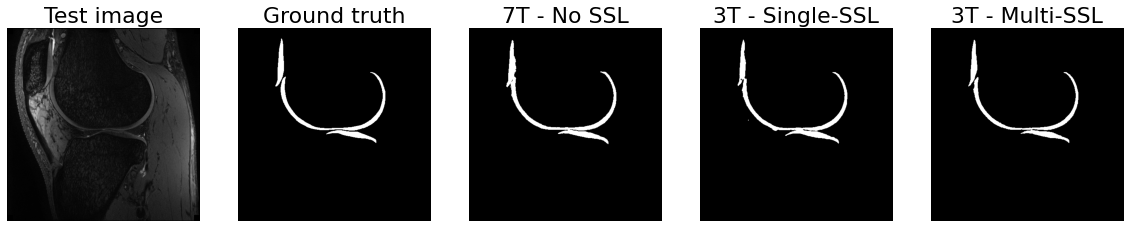

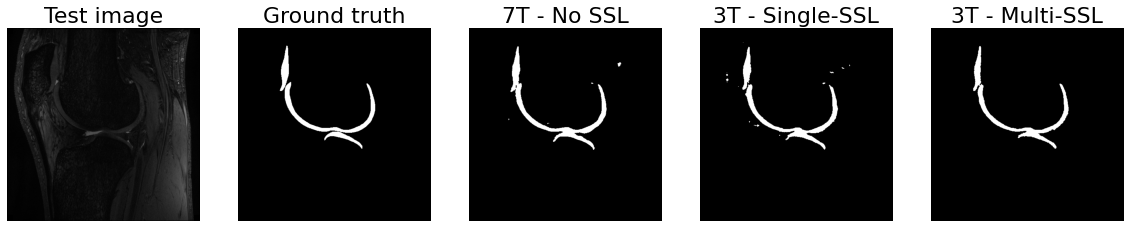

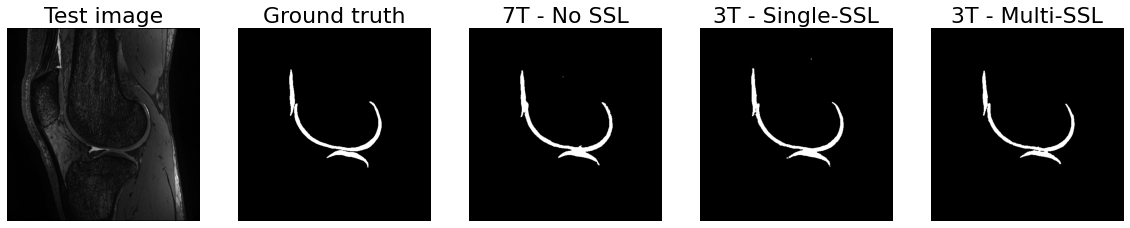

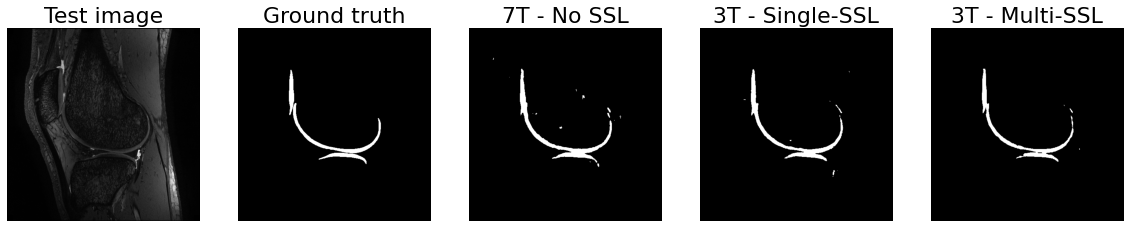

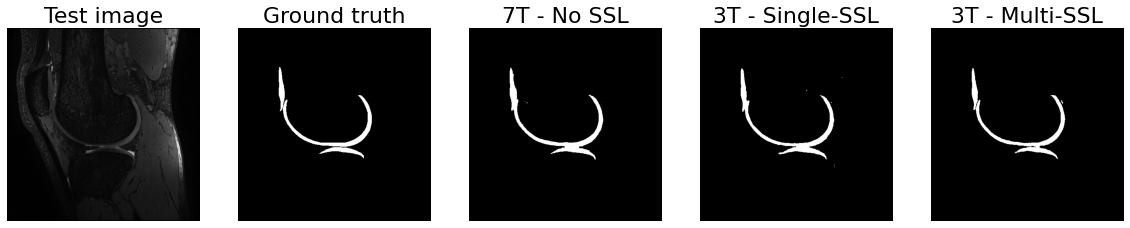

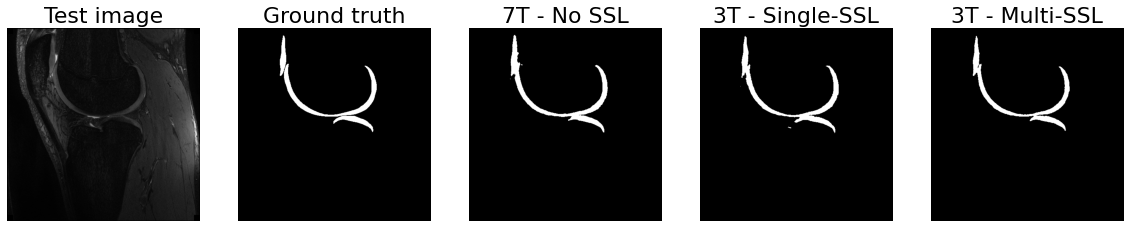

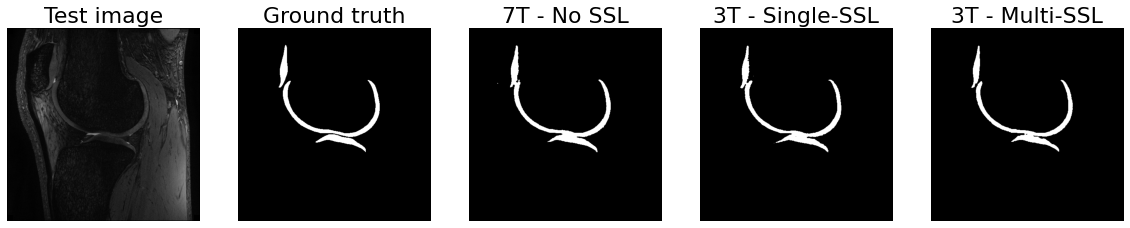

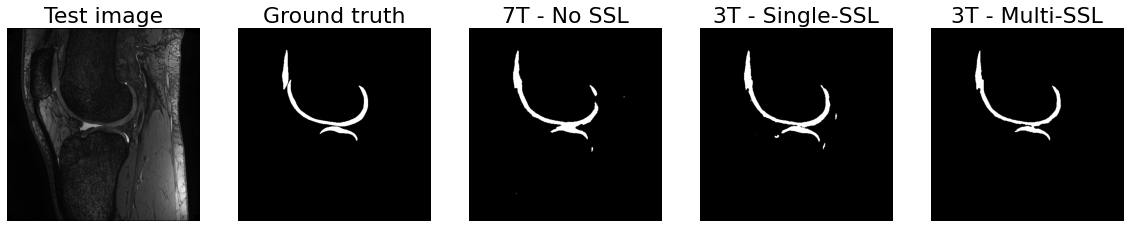

In [8]:
vis_batch = 0 # 0-3

title_list = ['7T - No SSL', '3T - Single-SSL', '3T - Multi-SSL']


for i in range(len(pred_masks[0])): # no. of rows 

    X_test = test_ds[vis_batch*batch_size + i][0][0, :, :].numpy() # image
    y_test = test_ds[vis_batch*batch_size + i][1][0, :, :].numpy() # label

    nrows = 1
    ncols = 2 + len(all_pred_masks)
    

    fig, ax = plt.subplots(nrows, ncols, figsize = (ncols*4, nrows*4))


    ax[0].imshow(X_test, cmap='gray')
    ax[0].axis('off')
#         ax[0].set_title('Test image_'+str(i))
    ax[0].set_title('Test image', fontsize=22)
    ax[1].imshow(y_test, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Ground truth', fontsize=22)


    for j in range(len(all_pred_masks)):
        preds = all_pred_masks[j][vis_batch] # shape = (32, 1, 256, 256) batch_size, num_channels, height, width

        y_pred = preds[i, 0, ...]
        ax[2+j].imshow(y_pred, cmap='gray')
        ax[2+j].axis('off')
        ax[2+j].set_title(title_list[j], fontsize=22)

# plt.savefig('7TSeg_app_4.pdf', dpi=400, bbox_inches='tight')
plt.show()